# OpenStreetMap Case Study

In this notebook, I am going to look at an area from [OpenStreetMap](http://www.openstreetmap.com) website and use data wrangling techniques to assess the quality of the dataset on a selected area, clean the data, and also run SQL queries to answer some interesting questions about the area.

## Choosing the Map Area

Since I have been living in **Portland, OR** for the past 5 years and this is a city that I have had great experiences in, I decided to choose this area for this project. I downloaded the dataset in XML format from the list of *"most popular extracts"* that exist on the OpenStreetMap website. Below is the link to the dataset file used in this case study.

[https://mapzen.com/data/metro-extracts/metro/portland_oregon/](https://mapzen.com/data/metro-extracts/metro/portland_oregon/)

## Problems Encountered in the Map

Since the dataset selected for this case study is very large (about 1.6 GB), I used the code below (adapted from Udacity Data Wrangling course) to extract a sample dataset from the file and assess the quality of different fields.

In [72]:
# Yield element if it is the right type of tag
def get_element(osm_file, tags=('node', 'way', 'relation')):

    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()
            
# Write a section of the dataset to a new XML file
def extract_sample(SAMPLE_FILE, OSM_FILE):
    with open(SAMPLE_FILE, 'wb') as output:
        output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        output.write('<osm>\n  ')

        # Write every 10th top level element
        for i, element in enumerate(get_element(OSM_FILE)):
            if i % 10 == 0:
                output.write(ET.tostring(element, encoding='utf-8'))

Looking at different fields using the sample dataset, I found a few issues with the dataset that I am going to discuss next.

### *1. Way Elements With Less Than Two Nodes*

According to OpenStreetMap documentation, "A way is an ordered list of nodes which normally also has at least one tag or is included within a Relation. A way can have between 2 and 2,000 nodes, although it's possible that faulty ways with zero or a single node exist."
Using the following function, I found that there were **46** "faulty" way elements in the dataset that had less than 2 nodes. This is something that needs to be fixed to make the dataset more complete and reliable.


In [75]:
# Determine the number of way elements that have less than 2 nodes
def incomplete_ways(osm_file):
    incomplete_way_count = 0

    for event, element in ET.iterparse(osm_file):
        num_nds = 0
        if element.tag == 'way':
            for nd in element.iter('nd'):
                num_nds += 1

            if num_nds < 2:
                incomplete_way_count += 1

### *2. Inconsistent City Names*

Looking through the sample dataset, I found out that the extract that I downloaded from the website includes not only Portland area, but also several small towns and suburbs around Portland in Oregon (such as Beaverton, Gresham, Lake Oswego) and also some small towns across the border in Washington state (such as Vancouver and Camas).

The issue with this field was that in several cases, mutliple names were used to refer to the same place. For example, **portland** - **Portland** - **Portland, OR** - and **Portland, Oregon** were all names that existed in the addr:city field. Some other examples of inconsistencies in city names included "**St. Helens** - **St Helens** - **Saint Helens**", "**Beaverton, OR** - **Beaverton**". The following function was used to make the city names more consistent in the dataset.

In [76]:
#Function to make the city names consistent.
def clean_cities(element):
    if element.tag == "node" or element.tag == "way":
        for tag in element.iter('tag'):            
            if tag.attrib["k"] == "addr:city":
             # Find city names with "." or "," followed by characters, delete the extra part 
                tag.attrib['v'] = re.sub(r',\s*.*$|\.', "", tag.attrib['v'])
            # Capitalize the first letter of all cities
                tag.attrib['v'] = tag.attrib['v'].title()
            # Replacing Saint with St to deal with a couple of inconsistent instances
                if "Saint" in tag.attrib['v']:
                    tag.attrib['v'] = tag.attrib['v'].replace("Saint", "St")

### *3. Multiple Housenumbers in One Record*

As I was checking the "addr:housenumber" tag in nodes and ways, I noticed that a big portion of data included multiple numbers in this tag as the value. This is probably due to the fact that these nodes and ways refer to a complex with multiple apartment numbers, or an area with buildings adjacent to each other that are included in one node or one way. These values appeared in three formats in "addr:housenumber" tag, e.g. "*813,815,817*" - "*1222-1242*" - "*917;919*".

Since in relational databases, we cannot have a record with mutliple values in one field, this was an issue that needed to be fixed in the dataset. The following function was used to split the value with multiple numbers into individual numbers, remove the tag with multiple numbers, and then append mutliple tags to the parent node/way, one tag for each number. For the values that represented a range of numbers (e.g."*1222-1242*"), the code splits the value into two numbers and attaches "*s*" to the first number and "*e*" to the second number.

In [22]:
# Function to check if a value is a list/range of numbers.
def is_list_of_numbers (num):
    pattern = re.compile(r'[,;-](\s?)[0-9]') 
    m = pattern.search(num)
    if m:
        return True
    else:
        return False
    
#Function to split the housenumbers consisting of multiple numbers
#into a list of individual numbers.
def separate(x, separators = [",", ";"]):
    for separator in separators:
        #find the value with separatros "," or ";" in them
        if  separator in x:
            x = x.replace(" ", "")
            separate_nums = x.split(separator)
            return separate_nums
    # If the value is a range of numbers with "-" separating the numbers split the value at "-"   
    if "-" in x:
        x = x.replace(" ", "")  #remove any extra spaces in the value
        separate_nums = x.split("-")
        separate_nums[0] += "s"  #Attach "s" to the first number
        separate_nums[1] += "e"  #Attach "e" to the second number
        return separate_nums
    
#Function to remove tags with mixed housenumber and append tags
#with individual housenumbers.
def clean_housenumber(element):
        if element.tag == 'way' or element.tag == 'node':
            for tag in element.iter('tag'):
                if tag.attrib["k"] == "addr:housenumber" and is_list_of_numbers(tag.attrib["v"]):
                    element.remove(tag)   #remove the tag with addr:housenumber as value
                    #append tags to the parent node/way with split up housenumbers as the value
                    for num in separate(tag.attrib["v"]):
                        element.append(ET.Element("tag", {"k":"addr:housenumber", "v":num}))


### *4. Inconsistent State Names*

Another inconsistency noticed in the dataset was related to "addr:state" tag value in several nodes and ways. The dataset included names such as **Oregon, OR, or, Or** and also **Washington, WA, Wa** in the state tag. Using the function below, I converted all the state names so that they are either "OR" or "WA". 

In [77]:
#Function to make the state names consistent.
def clean_state(element):
    OR_pattern = re.compile(r'[Oo][Rr]') #Find all the patterns that refer to Oregon in the dataset
    WA_pattern = re.compile(r'[Ww][Aa]') #Find all the patterns that refer to Washington in the dataset

    if element.tag == "node" or element.tag == "way":
        for tag in element.iter("tag"):
            if tag.attrib["k"] == "addr:state":
                OR_match = OR_pattern.search(tag.attrib['v'])
                WA_match = WA_pattern.search(tag.attrib['v'])
                if tag.attrib['v'] != "OR" and not WA_match:
                    tag.attrib['v'] = 'OR'
                if tag.attrib['v'] != "WA" and not OR_match:
                    tag.attrib['v'] = 'WA'

### *5. Street Names with Inconsistent Directions*

Looking through the street name values for "addr:street" tags, I found out that street directions have been refered to in different ways. For example, we see "**N.W.**" - "**NW**" - "**Northwest**" all refering to the same direction. This field is one of the fields that is used later in one of the queries run on the dataset, so I decided to clean this field as well by mapping all the direction names to a standard direction name as follows:

In [78]:
#Function to update a name using the provided mapping
def update_name(name, mapping):
    for key in mapping:
        if name.startswith(key):
            name = name.replace(key, mapping[key])
            break
    return name

mapping = {"W ": "West ", "W.": "West", "S ": "South ", "S.": "South", "N ": "North ", "N." : "North", "E ": "East ", "E.": "East", "SE": "Southeast", "S.E.": "Southeast", "NW": "Northwest", "N.W.": "Northwest ", "N.E.": "Northeast", "NE": "Northeast", "SW": "Southwest", "S.W.": "Southwest"}

#Function to make the street direction names consistent (West, Northeast, Northwest, South, etc.)
def clean_area(element):
    if element.tag == "node" or element.tag == "way":
        for tag in element.iter("tag"):
            if tag.attrib["k"] == "addr:street":
                tag.attrib["v"] = update_name(tag.attrib["v"], mapping)

I also investigated the data to make sure there were no problematic characters in any tag values and also to make sure that all timestamps have the correct format. No issues were found in those fields. Below are the functions that were used for this investigation.

In [79]:
# Function to create a dictionary of all the tag values with problematic characters 
# (adapted from Udacity Data Wrangling course)
def problem_char(osm_file):
    problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
    problem_dict = defaultdict(int)

    for event, element in ET.iterparse(osm_file):
        if element.tag == "tag" and element.attrib["k"] is not None:
            problem_m = problemchars.search(element.attrib["k"])
            if problem_m:
                problem_dict[problem_m.group()] += 1

In [80]:
# Function to create a dictionary of all the timestamps that do not follow the given 
# pattern (i.e. 2010-03-23T19:00:46Z)
def check_timestamp(osm_file):
    timestamp = re.compile(r'[2000-2018]-[0-1][0-9]-[0-3][0-9]T\d\d:\d\d:\d\dZ')
    time_dict = defaultdict(int)
    tags = ["way", "node", "relation"]

    for event, element in ET.iterparse(osm_file):
        if element.tag in tags:
            time_m = timestamp.search(element.attrib["timestamp"])
            if time_m:
                time_dict[time_m.group()] += 1

## Converting the Dataset to CSV Files

After defining the required functions to clean some of the problematic fields in the dataset, it is time to convert the XML file to CSV files that are going to be used in queries on the dataset to answer some interesting questions about the area. Based on the recommendation from the course, after cleaning the data, five CSV files were created including "ways.csv", "nodes.csv", "nodes_tags", "ways_tags", and "ways_nodes" from the data using the dictionaries shaped for each element (adapted from the course). The code below was adapted from the Data Wrangling case study and cleaning functions were added to it.

In [81]:
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

# Function to create a dictionary for each way and node element of the XML file
def shape_element(element, default_tag_type='regular'):
    
    # clean the element before creating the dictionary
    clean_cities(element)
    clean_housenumber(element)
    clean_state(element)
    clean_area(element)
    
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []

    if element.tag == 'node':
        # create a dictionary for each node to contain node attributes
        node_attribs = {"id": element.attrib["id"], "user": element.attrib["user"], "uid": element.attrib["uid"], "version": element.attrib["version"], "lat": element.attrib["lat"], "lon": element.attrib["lon"], "timestamp": element.attrib["timestamp"], "changeset": element.attrib["changeset"]}
        # create a dictionary to contain node tags with the course instructions (separating the characters before
        # and after ":")
        for tag in element.iter('tag'):
            if ":" not in tag.attrib["k"]:
                key1 = tag.attrib["k"]
                type1 = default_tag_type
            else:
                key1 = tag.attrib["k"].split(":", 1)[1]
                type1 = tag.attrib["k"].split(":", 1)[0]
            tags.append({"id": element.attrib["id"], "key": key1, "value": tag.attrib["v"], "type": type1})

        return {'node': node_attribs, 'node_tags': tags}

    elif element.tag == 'way':
        # create a dictionary for each way to contain way attributes
        way_attribs = {"id": element.attrib["id"], "user": element.attrib["user"], "uid": element.attrib["uid"], "version": element.attrib["version"], "timestamp": element.attrib["timestamp"], "changeset": element.attrib["changeset"]}
        # create a dictionary to contain way tags with the course instructions (separating the characters before
        # and after ":")
        for tag in element.iter('tag'):
            if ":" not in tag.attrib["k"]:
                key1 = tag.attrib["k"]
                type1 = default_tag_type
            else:
                key1 = tag.attrib["k"].split(":", 1)[1]
                type1 = tag.attrib["k"].split(":", 1)[0]
            tags.append({"id": element.attrib["id"], "key": key1, "value": tag.attrib["v"], "type": type1})
            
        position = 0 # initializing the variable to be used as the position of each node tag within a way element
        # shape the way nodes key of the way dictionary
        for nd in element.iter('nd'):     
            way_nodes.append({"id": element.attrib["id"], "node_id": nd.attrib["ref"], "position": counter})
            position += 1

        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

In [82]:
# Extend csv.DictWriter to handle Unicode input (adapted from the Data Wrangling course)
class UnicodeDictWriter(csv.DictWriter, object):

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

# Iteratively process each XML element and write to csv(s)
def process_map(file_in):

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        for element in get_element(file_in, tags=('node', 'way')):

            el = shape_element(element)

            if el:

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


The CSV files were written WITHOUT header. The reason is that importing CSV tables with headers into SQL tables that were created with INTEGER fields in the schema will lead to a "Datatype Mismatch" error.

## Dataset Statistics

Below you can find some statistics about the data extract from the OpenStreetMap website.

In [43]:
portland_data = 'portland_oregon.osm'

### *XML File Size in MegaBytes*

In [45]:
import os
os.path.getsize(portland_data)/1000000

1609

### *Number of Elements in the Data*

In [47]:
from collections import defaultdict

tag_dict = defaultdict(int)

for event, element in ET.iterparse(portland_data):
    tag_dict[element.tag] += 1

print tag_dict

defaultdict(<type 'int'>, {'node': 6723229, 'nd': 7747536, 'bounds': 1, 'member': 69447, 'tag': 4996693, 'relation': 6602, 'way': 874736, 'osm': 1})


### *Number of Unique Users*

In [46]:
import xml.etree.cElementTree as ET

users = set()

for event, element in ET.iterparse(portland_data):
    if "uid" in element.attrib:
        users.add(element.attrib["uid"])

print len(users)

1475


### *Number of Updates to Dataset Per Year (Based on Timestamp)*

In [55]:
time_dict = defaultdict(int)
tags = ["node", "way", "relation"]
for event, element in ET.iterparse(portland_data):
    if element.tag in tags:
        time_dict[element.attrib["timestamp"][:4]] += 1
print time_dict

defaultdict(<type 'int'>, {'2009': 125498, '2008': 1538, '2007': 1398, '2015': 4994555, '2014': 220524, '2017': 453091, '2016': 587919, '2011': 486502, '2010': 127106, '2013': 136582, '2012': 469854})


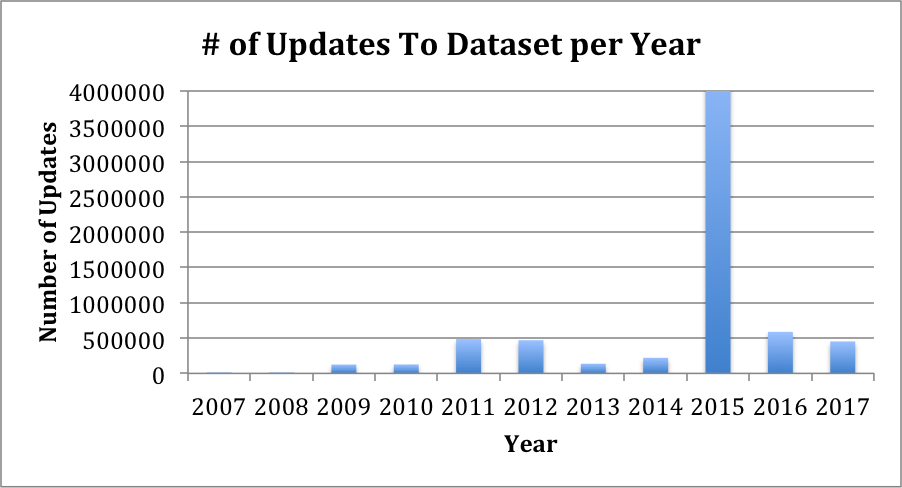

In [88]:
from IPython.display import Image
Image(filename = "updates.png", width = 600, height = 400)

It is interesting to see that in 2015, suddenly a huge number of updates were made to the dataset and then again the number of updates went down

### *Distribution of Number of Nodes per Way*

In [50]:
way_nodes_Query = '''
SELECT num_of_nodes, count(*) FROM
    (SELECT DISTINCT(ways_nodes.id), num_of_nodes FROM ways_nodes
    JOIN
    (SELECT count(*) as num_of_nodes, id FROM ways_nodes
    GROUP BY id
    ) as sub
    sub.id = ways_nodes.id) as i
GROUP BY num_of_nodes;
'''

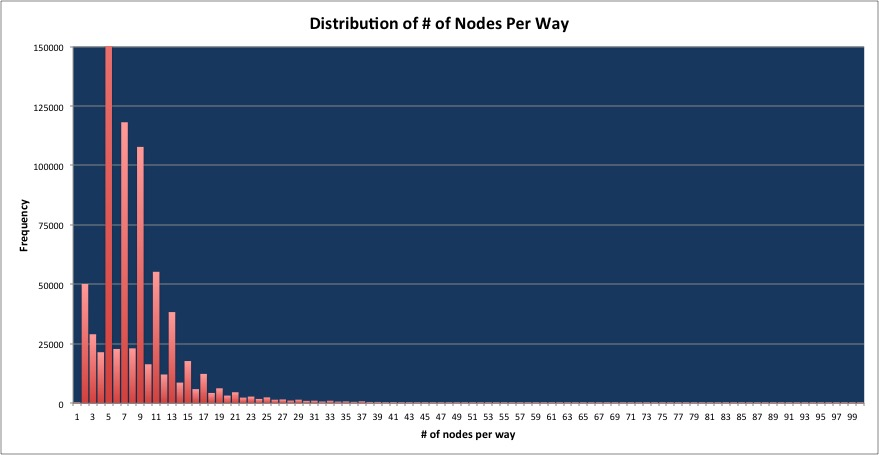

In [85]:

Image(filename = "Distribution.jpg", width = 1000, height = 600)

As the chart above shows, most of way elements are made of 5 nodes, and after that ways with 7 nodes and 9 nodes have the most frequency in the dataset.

## Data Queries 

In order to run queries, CSV files were imported into SQL tables and **sqlite3** library was used to connect the Python code to the database and run the queries. Below you can find the queries that were run on the dataset and their results.

Portland is an area that is known for its food and breweries. Walking in different parts of the city, you can find all kinds of restaurants and bars that serve tasty food and great beers. In this section of the project, I ran some queries to find the number of breweries in the area (including the suburbs), number of pubs and bars in NW Portland (where I live) and the top fast food restaurants in the area.

In [1]:
import sqlite3

DB_file = 'portland_DB'

db = sqlite3.connect(DB_file)
c = db.cursor()

In [2]:
# Function to print the results of SQL in a readable way
def print_query (result):
    for row in result:
        x = ""
        for item in row:
            x += str(item) + "  |  "
        print  x

### *How many of bars, restaurants, and pubs in the area are breweries? *

In [61]:
brewery_Query = '''
SELECT count(DISTINCT(i.id)) FROM
    (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as i
    JOIN
    (SELECT DISTINCT(id) FROM
        (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as i
    WHERE key = 'amenity'
    AND (value = 'restaurant' OR value = 'pub' OR value = 'bar')
    ) as j
    ON i.id = j.id
WHERE (key = 'microbrewery' AND value = 'yes') OR (key = 'name' AND value LIKE '%brew%');
'''

In [60]:
c.execute(brewery_Query)
rows = c.fetchall()
print_query(rows)

69  |  


### *How many pubs and bars are in NW Portland?*

In [63]:
NW_Query = '''
SELECT count(*) FROM
        (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as i
        JOIN
        (SELECT DISTINCT(id) FROM
            (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as i
        WHERE key in ('city', 'amenity') AND (value in ('Portland', 'pub') OR value in ('Portland', 'bar'))
        GROUP BY i.id
        HAVING count(*) = 2
        ) as j
        ON i.id = j.id
WHERE i.key = 'street' AND i.value LIKE '%Northwest%';
'''

In [64]:
c.execute(NW_Query)
rows = c.fetchall()
print_query(rows)

51  |  


### *Top 10 fast food restaurants in the area*

In [3]:
fast_food_Query = '''
SELECT value, count(*) as num FROM
    (SELECT * FROM
        (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as i
        JOIN
        (SELECT DISTINCT(id) FROM
            (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) as i
            WHERE key = 'amenity' AND value = 'fast_food'
        ) as J
        ON i.id = j.id
    WHERE i.key = 'name'
    )
GROUP BY value
ORDER BY num desc limit 10;
'''

In [4]:
c.execute(fast_food_Query)
rows = c.fetchall()
print_query(rows)
db.close()

Subway  |  143  |  
McDonald's  |  75  |  
Taco Bell  |  56  |  
Burger King  |  39  |  
Wendy's  |  32  |  
Jack in the Box  |  30  |  
Burgerville  |  27  |  
Panda Express  |  26  |  
Carl's Jr.  |  21  |  
Chipotle  |  21  |  


## Idea for Improvement - Nodes vs Ways and What They Represent

One of the issues that makes this dataset inconsistent is the fact that certain items on the map exist in both “node” elements and “way” elements (specifically closed ways where first and last nodes are the same). As an example, the query below shows the number of “amenity" tags  in “ways” and “nodes”.

In [67]:
amenity_Query = '''
SELECT count(DISTINCT(id)) FROM nodes_tags
WHERE key = 'amenity'
UNION
SELECT count(DISTINCT(id)) FROM ways_tags
WHERE key = 'amenity';
'''
c.execute(amenity_Query)
rows = c.fetchall()
print_query(rows)

11280  |  
12647  |  


The first result (11280) is the number of "node" elements representing amenities in the area and the second result (12467) is the number of amenities represented in "way" elements. As you can see, the results are alomst equally split between nodes and ways. Further investigation reveals that we can find almost all types of amenities in both elements. This has multiple disadvantages including increasing processing time for auditing, cleaning, and querying the data and also making SQL queries longer and more complicated.

Standardizing the items that are included in each element in the dataset would definitely make the data cleaner and more easily understandable. Closed ways should refer to large enough areas that cannot be represent by a single node. This way we can come up with a better definition of nodes vs ways in the dataset.